#Analisi dati circuiti1

## Dipendenze

In [ ]:
from google.colab import drive
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sp

dir = "/content/drive/MyDrive/Lab2/Circuiti1"
drv = "/content/drive"

if not os.path.ismount(drv):
    drive.mount(drv, force_remount=True)
os.chdir(dir)

if "iminuit" not in sys.modules:
  %pip install iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares

## Resistenze interne

**Misura Rv** \\
Tensione = 5 V \\
Corrente misurata = 17 μA \\
Resistenza usata = 302,1 KΩ

In [ ]:
R_rv = 302_100
V_i = 5
I_rv = 17e-6

Rv = (R_rv*V_i) / (I_rv*R_rv - V_i)
print(f"Resistenza interna voltmetro = {Rv:_.0f}")

Resistenza interna voltmetro = 11_131_172


In [ ]:
#calcolo incertezza resistenza Voltmetro
R_rv_err = 100
V_i_err = .001
I_rv_err = 1e-8

den1 = (I_rv*R_rv - V_i)**2
dR1 = (V_i**2) / den1
dV = (R_rv**2 * I_rv) / den1
dI1 = (R_rv**2 * V_i) / den1

Rv_err = np.sqrt(dR1**2 * R_rv_err**2 + dV**2 * V_i_err**2 + dI1**2 * I_rv_err**2)
print(f"Incertezza su resistenza interna voltimetro: {Rv_err:_.3f}")

Incertezza su resistenza interna voltimetro: 294_852.567


**Misura Ra** \\
Tensione = 2.5V \\
Corrente misurata = 173 mA \\
Resistenza usata = 12.9 Ω

In [ ]:
R_ra = 12.9
I_ra = 173e-3
V_i = 2.5

Ra = (V_i - I_ra * R_ra) / I_ra
print(f"Resistenza interna amperometro = {Ra:_.3f}")

Resistenza interna amperometro = 1.551


In [ ]:
#Calcolo Restistenza Amperometro
R_ra_err = 0.1
I_ra_err= 1e-8
Ra_err = np.sqrt((1**2)*(R_ra_err**2) + (1/I_ra**2)*(V_i_err**2)+(V_i/I_ra)**2*(I_ra_err**2))
print (f"Errore su resistenza interna amperometro: {Ra_err:_.3f}")


Errore su resistenza interna amperometro: 0.100


##Verifica I legge di Ohm

**Verifica legge di ohm su un singolo resistore**

m = 0.001 ± 0.000
q = -0.000 ± 0.000

Goodness of the fit: True
Minuit Q2: 0.000862299454273083
Associated p-value: 1.0

Resistenza ottenuta: 998.606 Ω
Incertezza sulla resistenza: 17.613

Distanza in deviazioni standard tra valore atteso e misurato: 0.079


[]

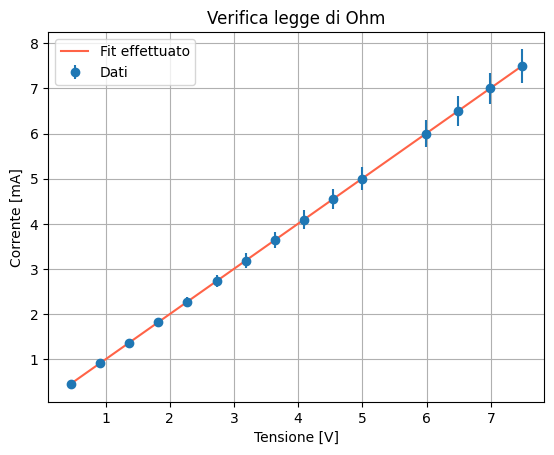

In [46]:
#@title FIT legge di Ohm
def LinearModel(x,m,q):
  return m* x + q

path_1 = "legge_di_ohm.xlsx"
dati_1 = pd.read_excel(path_1)

R_singolo = 1_000 #Ω
R_singolo_err = 0.1

V1 = dati_1["V"] #V
I1_mA = dati_1["I"] #mA
I1 = [i*1e-3 for i in I1_mA] #A
I1_error = [i*1e-3 for i in dati_1["I_std"]]

R_true_ohm = R_singolo
q_true_ohm = .0

LS_ohm = LeastSquares(V1, I1, I1_error, LinearModel)
MM_ohm = Minuit(LS_ohm, m = R_singolo, q = q_true_ohm)
MM_ohm.migrad()
MM_ohm.hesse()

#Risultati fit
for par, val, err in zip(MM_ohm.parameters, MM_ohm.values, MM_ohm.errors):
    print(f'{par} = {val:.3f} ± {err:.3f}')

print(f'\nGoodness of the fit: {MM_ohm.valid}')
print(f'Minuit Q2: {MM_ohm.fval}')
print(f'Associated p-value: {1. - sp.chi2.cdf(MM_ohm.fval, df = MM_ohm.ndof)}')

#Risultati per la resistenza
print(f"\nResistenza ottenuta: {1/MM_ohm.values[0]:_.3f} Ω")

inc_ohm = 1/MM_ohm.values[0]**2 * MM_ohm.errors[0] # ottenuta propagando l'errore come 1/x
print(f"Incertezza sulla resistenza: {inc_ohm:_.3f}")

#Compatibilità tra resistenza ottenuta e resistenza misurata
sigma_eq = np.sqrt(inc_ohm**2+R_singolo_err**2)
t = abs(1/MM_ohm.values[0]-R_singolo)/sigma_eq
print(f"\nDistanza in deviazioni standard tra valore atteso e misurato: {t:_.3f}")

#Plot del grafico
x1=np.linspace(min(V1), max(V1))
y1=LinearModel(x1, MM_ohm.values[0], MM_ohm.values[1])*1e3

plt.errorbar(V1, I1_mA, [i*1e3 for i in I1_error], label="Dati", fmt="o")
plt.plot(x1, y1, label="Fit effettuato", color="tomato")
plt.title("Verifica legge di Ohm")

plt.xlabel("Tensione [V]")
plt.ylabel("Corrente [mA]")
plt.grid()
plt.legend()
plt.plot()


**Verifica legge di ohm su resistori in serie**

m = 0.000004 ± 0.0000001
q = -0.000000 ± 0.0000003

Goodness of the fit: True
Minuit Q2: 0.006862069099857524
Associated p-value: 0.9999999999942417

Resistenza ottenuta: 243_379.739 Ω
Incertezza sulla resistenza: 6_205.150

t-test: 0.9057413139414262


[]

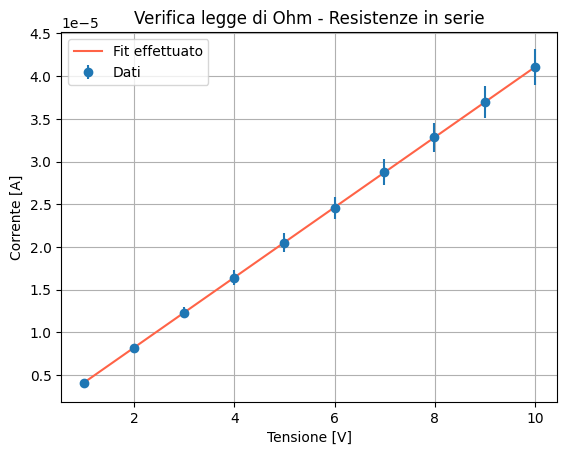

In [ ]:
#@title FIT resistori in serie

path_2 = "Misure_serie.xlsx"
dati_2 = pd.read_excel(path_2)

R1_serie = 149_000 #Ω
R2_serie = 100_000

V2 = dati_2["V"] #V
I2_microA = dati_2["I"] #μA
I2 = [i*1e-6 for i in I2_microA] #A
I2_error = [i*1e-6 for i in dati_2["I_std"]]

R_true_serie = 249_000 #Ω
R_true_serie_err = 0.1
q_true_serie = .0

LS_serie = LeastSquares(V2, I2, I2_error, LinearModel)
MM_serie = Minuit(LS_serie, m = 1/R_true_serie, q = q_true_serie)
MM_serie.migrad()
MM_serie.hesse()

for par, val, err in zip(MM_serie.parameters, MM_serie.values, MM_serie.errors):
    print(f'{par} = {val:.6f} ± {err:.7f}')

print(f'\nGoodness of the fit: {MM_serie.valid}')
print(f'Minuit Q2: {MM_serie.fval}')
print(f'Associated p-value: {1. - sp.chi2.cdf(MM_serie.fval, df = MM_serie.ndof)}')

print(f"\nResistenza ottenuta: {1/MM_serie.values[0]:_.3f} Ω")

inc_serie = 1/MM_serie.values[0]**2 * MM_serie.errors[0] # ottenuta propagando l'errore come 1/x
print(f"Incertezza sulla resistenza: {inc_serie:_.3f}")

sigma_eq_serie = np.sqrt(inc_serie**2+R_true_serie_err**2)
t_serie= abs(1/MM_serie.values[0]-R_true_serie)/sigma_eq_serie
print(f"\nt-test: {t_serie}")

x1_serie=np.linspace(min(V2), max(V2))
y1_serie=LinearModel(x1_serie, MM_serie.values[0], MM_serie.values[1])

plt.errorbar(V2, I2, I2_error, label="Dati", fmt="o")
plt.plot(x1_serie, y1_serie, label="Fit effettuato", color="tomato")
plt.title("Verifica legge di Ohm - Resistenze in serie")

plt.xlabel("Tensione [V]")
plt.ylabel("Corrente [A]")
plt.grid()
plt.legend()
plt.plot()


# Resistenza aspettata = 249_000

**Verifica legge di ohm su resistori in parallelo**

m = 2.17E-05 ± 5.20E-07
q = 2.32E-09 ± 1.35E-06

Goodness of the fit: True
Minuit Q2: 0.001361154855884439
Associated p-value: 0.9999999999999911

Resistenza equivalente attesa: 46217.59259259259
Errore sulla resistenza equivalente attesa: 0.48547426825155443

Resistenza ottenuta: 46_105.486 Ω
Incertezza sulla resistenza: 1_105.602

Distanza in deviazioni standard tra valore di resistenza atteso e misurato: 0.101


[]

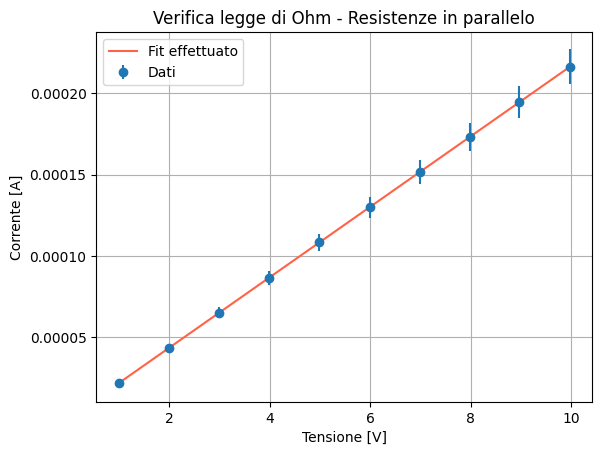

In [ ]:
#@title FIT resistori in parallelo

path_3 = "Misure_paral.xlsx"
dati_3 = pd.read_excel(path_3)

R1_paral = 149_000 #Ω
R2_paral = 67_000
somma_paral = R1_paral + R2_paral #serve per semplificare i calcoli di R_true_paral_err
R1_paral_err = 1
R2_paral_err = 1

V3 = dati_3["V"] #V
I3_microA = dati_3["I"] #μA
I3 = [i*1e-6 for i in I3_microA] #A
I3_error = [i*1e-6 for i in dati_3["I_std"]] #A


R_true_paral = (R1_paral * R2_paral) / (R1_paral + R2_paral)
R_true_paral_err = np.sqrt(((R1_paral/(somma_paral))**4)*(R1_paral_err)**2+((R2_paral/(somma_paral))**4)*(R2_paral_err)**2)
q_true_paral = .0

LS_paral = LeastSquares(V3, I3, I3_error, LinearModel)
MM_paral = Minuit(LS_paral, m = R_true_paral, q = q_true_paral)
MM_paral.migrad()

inc_paral = (1/MM_paral.values[0]**2) * MM_paral.errors[0] # ottenuta propagando l'errore come 1/x

#Stampa dei risultati
for par, val, err in zip(MM_paral.parameters, MM_paral.values, MM_paral.errors):
    print(f'{par} = {val:.2E} ± {err:.2E}')

print(f'\nGoodness of the fit: {MM_paral.valid}')
print(f'Minuit Q2: {MM_paral.fval}')
print(f'Associated p-value: {1. - sp.chi2.cdf(MM_paral.fval, df = MM_paral.ndof)}')

print(f'\nResistenza equivalente attesa: {R_true_paral}')
print(f'Errore sulla resistenza equivalente attesa: {R_true_paral_err}')

print(f"\nResistenza ottenuta: {1/MM_paral.values[0]:_.3f} Ω")
print(f"Incertezza sulla resistenza: {inc_paral:_.3f}")

#Compatibilità tra resistenza ottenuta e resistenza misurata
sigma_eq_paral = np.sqrt(inc_paral**2+R_true_paral_err**2)
t_paral = abs(1/MM_paral.values[0]-R_true_paral)/sigma_eq_paral
print(f"\nDistanza in deviazioni standard tra valore di resistenza atteso e misurato: {t_paral:_.3f}")

#Plot del grafico
x1_paral=np.linspace(min(V3), max(V3))
y1_paral=LinearModel(x1_paral, MM_paral.values[0], MM_paral.values[1])

plt.errorbar(V3, I3, I3_error, label="Dati", fmt="o")
plt.plot(x1_paral, y1_paral, label="Fit effettuato", color="tomato")
plt.title("Verifica legge di Ohm - Resistenze in parallelo")

plt.xlabel("Tensione [V]")
plt.ylabel("Corrente [A]")
plt.grid()
plt.legend()
plt.plot()


##Partitore resistivo

**Considerazioni** \\

Affinché $V_{out} = \frac{1}{2}V_{in}$, senza considerare $R_{load} ⇒ R_{1} = R_{2}$

\\

Se $ \frac{1}{R_{out}} = \frac{1}{R_{2}} + \frac{1}{R_{load}}$, affinché $R_{out} ≃ R_{2} ⇒ R_{load} >> R_2$

\\

$R_1 = R_2 = $ 21.7 Ω \\
$V_{in} = $ 0.1 V \\

*Misure di V out* \\
load = 10 Ω ⟷ out = 0.028 V \\
load = 500 Ω ⟷ out 0.49 V \\
load = 10 kΩ ⟷ out = 0.051 V \\
load = 50 kΩ ⟷ out = 0.051 V \\
load = 100 kΩ ⟷ out = 0.051 V \\
load = 500 kΩ ⟷ out = 0.051 V \\
load = 1 MΩ ⟷ out = 0.051 V

##Misura del diodo

V è stato preso in mA \\
la resistenza del diodo dipende TANTO dalla temperatura, roba che soffiarci sopra la cambia notevolmente \\
l'amperometro era rotto e non andava l'impostazione sopra i 500

Gli errori sulla corrente sono sottostimati, per correggerli bisogna:
per valori sotto 500 micro ampere il valore fluttua per lo 0.055%
per i valori superiori fluttua per lo 0.054%

Bisogna moltiplicare per la perceentuale scritta il valore medio ottenuto, esso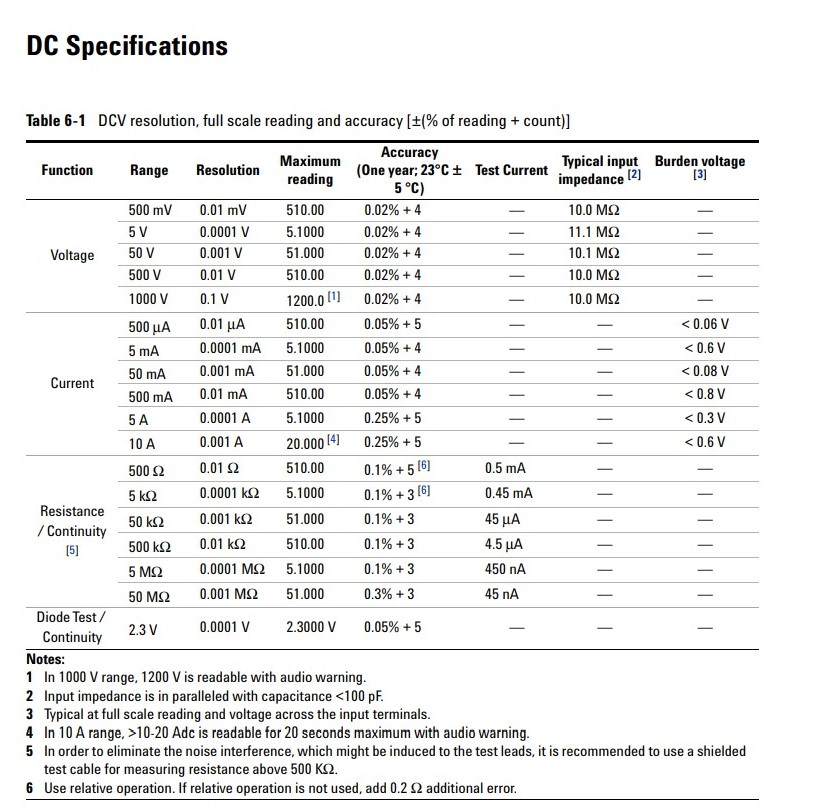

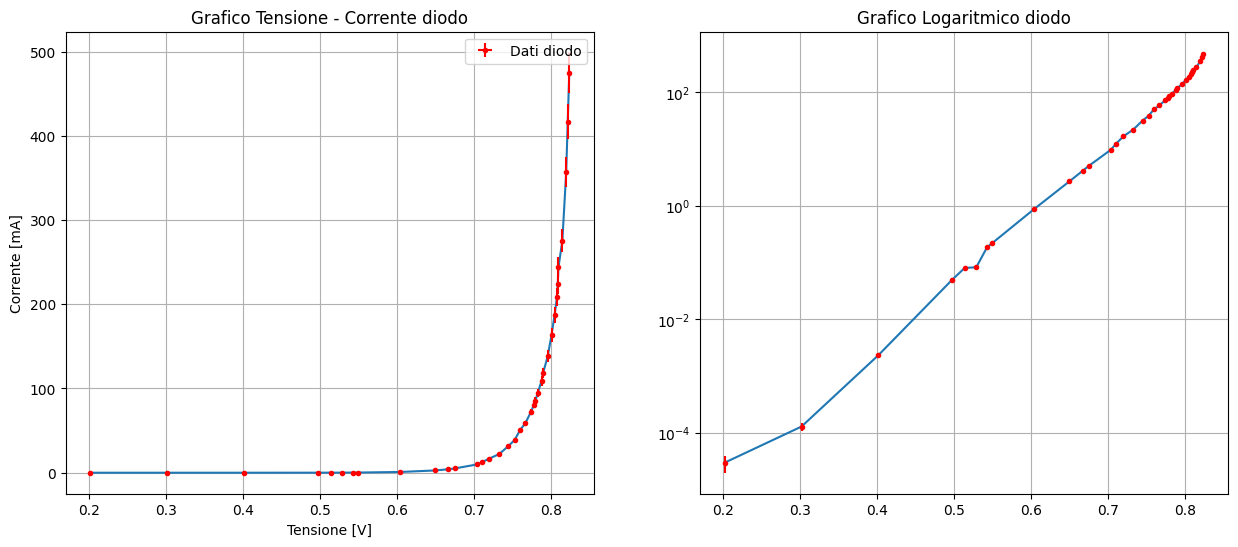

In [ ]:
#@title Plot misure diodo

path_4 = "Diodo_Aggiustato.xlsx"
dati_4 = pd.read_excel(path_4)

V4 = dati_4["V3"]
I4 = dati_4["I3"]

Verr = .001
#Ierr = [.05 * i for i in I4]
I4_err = dati_4["I_std"]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(V4, I4)
plt.errorbar(V4, I4, xerr= Verr, yerr= I4_err, fmt = "or", markersize=3,label="Dati diodo")
plt.title("Grafico Tensione - Corrente diodo")
plt.xlabel("Tensione [V]")
plt.ylabel("Corrente [mA]")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.yscale("log")
plt.plot(V4, I4)
plt.errorbar(V4, I4, xerr= Verr, yerr= I4_err, fmt = "or", markersize=3)
plt.title("Grafico Logaritmico diodo")
plt.grid()

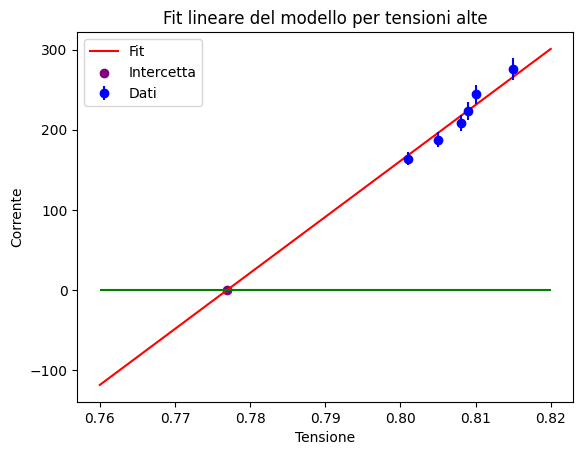


Valore dell'intercetta sull'asse x (V_soglia) = 0.777

Errore su V_soglia = 0.098


In [ ]:
#@title Plot grafico per trovare Vsoglia graficamente

from scipy.optimize import root_scalar

# punto massimo dal quale scendere
last = 3 # @param {type:"slider", min:0, max:34, step:1}
sup = len(I4) - last

# valore massimo del Chi quadro accettato
chi2_limite = 2.01 # @param {type:"slider", min:0.1, max:5, step:0.01}

N_punti = 0
m_best = 0
q_best = 0

for i in range(2, len(I4)):
  LS_diodo = LeastSquares (V4[sup-i:sup], I4[sup-i:sup], I4_err[sup-i:sup], LinearModel)
  MM_diodo = Minuit (LS_diodo, m = 0, q = 0)
  MM_diodo.migrad ()

  #print(MM_diodo.fval)

  if MM_diodo.fval >= chi2_limite:
    N_punti = i-1
    m_best = MM_diodo.values[0]
    q_best = MM_diodo.values[1]

    #display(MM_diodo)
    break

t = np.linspace(.76, V4[sup])
z = root_scalar(lambda x: LinearModel(x, m_best, q_best), bracket=[.75, .8])
#Calcolo errore sull'intercetta
V_soglia_err = np.sqrt((MM_diodo.errors[1]/m_best)**2 + (q_best*MM_diodo.errors[0]/(m_best)**2)**2)


plt.plot(t, LinearModel(t, m_best, q_best), color = "red", label = "Fit") # retta
plt.hlines(0,.76,.82, color = "green") # asse x

plt.errorbar(V4[sup-N_punti:sup], I4[sup-N_punti:sup], I4_err[sup-N_punti:sup], label = "Dati", fmt = "ob") # punti interpolati
plt.scatter(z.root, 0, color="purple", label = "Intercetta") # intercetta con x

plt.title("Fit lineare del modello per tensioni alte")
plt.xlabel("Tensione")
plt.ylabel("Corrente")

plt.legend()
plt.show()

print(f"\nValore dell'intercetta sull'asse x (V_soglia) = {z.root:_.3f}")
print(f"\nErrore su V_soglia = {V_soglia_err:_.3f}")

#Fit dei dati secondo legge di Shockley

Per poter valutare i parametri $I_0$ e g, abbiamo fittato i dati usando il modello completo e tutti i dati raccolti

g = 1.407E+00 ± 4.283E-03
i = 4.712E-08 ± 2.861E-09

Goodness of the fit: True
Minuit Q2: 304.1678881182204
Associated p-value: 0.0

g0 = 1.407, I0 = 4.712447040281241e-08


[]

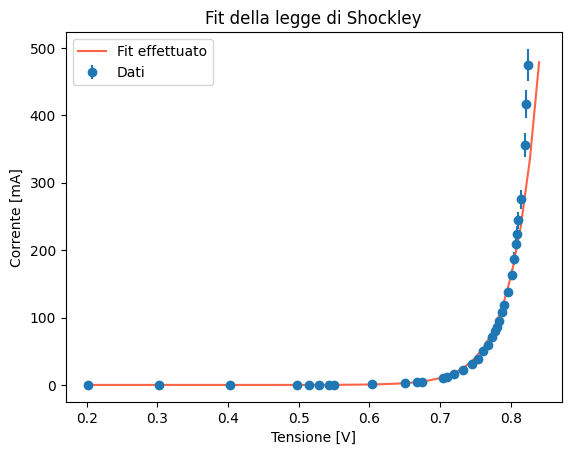

In [47]:
#@title Fit dati con legge di Shockley

LS_sho2 = LeastSquares(V4, I4, I4_err, Shockley)
MM_sho2 = Minuit(LS_sho2, g=g0, i=i0)
MM_sho2.migrad()
MM_sho2.hesse()

#Stampa dei risultati
for par, val, err in zip(MM_sho2.parameters, MM_sho2.values, MM_sho2.errors):
    print(f'{par} = {val:.3E} ± {err:.3E}')

print(f'\nGoodness of the fit: {MM_sho2.valid}')
print(f'Minuit Q2: {MM_sho2.fval}')
print(f'Associated p-value: {1. - sp.chi2.cdf(MM_sho2.fval, df = MM_sho2.ndof)}')
G, I = MM_sho2.values
print(f"\ng0 = {G:_.3f}, I0 = {I}")

#Plot del grafico
x1_shock=np.linspace(min(V4), 0.84)
y1_shock=Shockley(x1_shock, G, I)

plt.errorbar(V4, I4, I4_err, label="Dati", fmt="o")
plt.plot(x1_shock, y1_shock, label="Fit effettuato", color="tomato")
plt.title("Fit della legge di Shockley")

plt.xlabel("Tensione [V]")
plt.ylabel("Corrente [mA]")
plt.legend()
plt.plot()


#Grafico dei residui

Abbiamo deciso di fare il grafico dei residui in quanto il fit della legge di Shockley non ci soddisfa

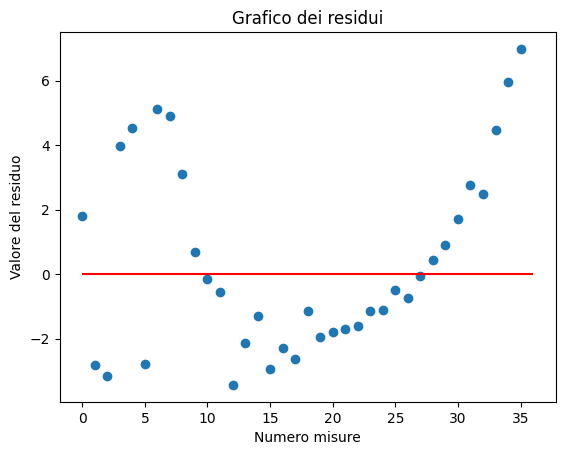

In [ ]:
#@title Grafico residui

N = len(I4)
res = np.zeros(N)
for i in range(N):
  res[i] = ( I4[i] - Shockley(V4[i], G, I) ) / I4_err[i]

plt.scatter(range(N), res)
plt.hlines(0, 0, N, "red")
plt.title("Grafico dei residui")
plt.xlabel("Numero misure")
plt.ylabel("Valore del residuo")
plt.show()

#Fit dei dati con legge di Shockley - eliminazione misure
Proviamo a eliminare certe misure osservando il grafico dei residui al fine di ottenere un risultato migliore

In [ ]:
#@title Fit dati con legge di Shockley eliminando le ultime misure

LS_sho3 = LeastSquares(V4[:-3], I4[:-3], I4_err[:-3], Shockley)
MM_sho3 = Minuit(LS_sho3, g=g0, i=i0)
MM_sho3.migrad()
MM_sho3.hesse()

#Stampa dei risultati
for par, val, err in zip(MM_sho3.parameters, MM_sho3.values, MM_sho3.errors):
    print(f'{par} = {val:.9f} ± {err:.9f}')

print(f'\nGoodness of the fit: {MM_sho3.valid}')
print(f'Minuit Q2: {MM_sho3.fval}')
print(f'Associated p-value: {1. - sp.chi2.cdf(MM_sho3.fval, df = MM_sho3.ndof)}')
G3, I3 = MM_sho3.values
print(f"g0 = {G3:_.3f}, I0 = {I3}")

display(MM_sho3)

g = 1.416802031 ± 0.004324303
i = 0.000000053 ± 0.000000003

Goodness of the fit: True
Minuit Q2: 190.193611517748
Associated p-value: 0.0
g0 = 1.417, I0 = 5.2768481668786726e-08


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 190.2 (χ²/ndof = 6.1)      │              Nfcn = 366              │
│ EDM = 2.93e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ g    │   1.417   │   0.004   │            │            │         │         │       │
│ 1 │ i    │  52.8e-9  │  3.2e-9   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────┐
│   │             g             i │
├───┼─────────────────────────────┤
│ g │      1.87e-05 13.475931e-12 │
│ i │ 13.475931e-12      9.94e-18 │
└───┴─────────────────────────────┘

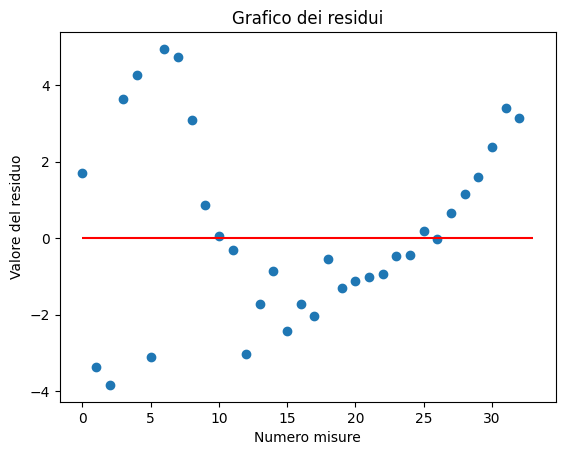

In [ ]:
#@title Grafico residui

N = len(I4[:-3])
res = np.zeros(N)
for i in range(N):
  res[i] = ( I4[i] - Shockley(V4[i], G3, I3) ) / I4_err[i]

plt.scatter(range(N), res)
plt.hlines(0, 0, N, "red")
plt.title("Grafico dei residui")
plt.xlabel("Numero misure")
plt.ylabel("Valore del residuo")
plt.show()